# Import packages

In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys, sys
from pathlib import Path
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break

from data_wrangling import specific_utils, process_monkey_information, general_utils
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from neural_data_analysis.neural_analysis_tools.get_neural_data import neural_data_processing
from neural_data_analysis.neural_analysis_tools.visualize_neural_data import plot_neural_data, plot_modeling_result
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from neural_data_analysis.topic_based_neural_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from neural_data_analysis.topic_based_neural_analysis.planning_and_neural import planning_and_neural_class, pn_utils, pn_helper_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv
from machine_learning.ml_methods import regression_utils, ml_methods_utils, regz_regression_utils, ml_methods_class, classification_utils, ml_plotting_utils
from neural_data_analysis.neural_analysis_tools.glm_tools import glm_class
from neural_data_analysis.topic_based_neural_analysis.planning_and_neural import planning_and_neural_class, pn_utils, pn_helper_class, pn_aligned_by_seg, pn_aligned_by_event
from neural_data_analysis.neural_analysis_tools.glm_tools.tpg import glm_bases, plot_glm_fit
import sys
import math
import gc
import subprocess
from pathlib import Path
from importlib import reload

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
from numpy import pi

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")

%load_ext autoreload
%autoreload 2

Set up logging configuration.
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Retrieve data

## get data

In [2]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"

In [3]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"

In [4]:
reload(pn_helper_class)

<module 'neural_data_analysis.topic_based_neural_analysis.planning_and_neural.pn_helper_class' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/neural_data_analysis/topic_based_neural_analysis/planning_and_neural/pn_helper_class.py'>

In [5]:
reduce_y_var_lags = False
planning_data_by_point_exists_ok = True
y_data_exists_ok = True

pn = pn_aligned_by_seg.PlanningAndNeuralSegmentAligned(raw_data_folder_path=raw_data_folder_path)
pn.prep_data_to_analyze_planning(planning_data_by_point_exists_ok=planning_data_by_point_exists_ok)
pn.planning_data_by_point, cols_to_drop = general_utils.drop_columns_with_many_nans(
    pn.planning_data_by_point)
pn.get_x_and_y_data_for_modeling(exists_ok=y_data_exists_ok, reduce_y_var_lags=reduce_y_var_lags)
pn.rebin_data_in_new_segments(segment_duration=2, rebinned_max_x_lag_number=2)

for col in ['cur_vis', 'nxt_vis', 'cur_in_memory', 'nxt_in_memory']:
    pn.rebinned_y_var[col] = (pn.rebinned_y_var[col] > 0).astype(int)

Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Schro/data_0416/binned_spikes_df_0p05.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Schro/data_0416/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-25cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Schro/data_0416/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-25cm_0cm
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Schro/data_0416/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
There are 5 duplicated point_index in bin_info. Note: one_point_index_per_bin is False
0.19% of rows are dropped in planning_data_by_bin due to having missing values
binned_spikes_df.shape: (208340, 87)
self.x_var.shape: (5602, 88)
self.y_var.shape: (5602, 37)
Getting y_var_reduced...
Loaded y_var_reduced from 

In [6]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

# design_df

In [ ]:
from neural_data_analysis.neural_analysis_tools.model_neural_data import design_bases
data = pn.rebinned_y_var.copy()
# spike_data = pn.rebinned_x_var['cluster_0']
dt = pn.bin_width

design_df, y, meta = design_bases.design_bases_for_behav_data(
    dt=dt, trial_ids=data["new_segment"],
    cur_vis=data["cur_in_memory"], nxt_vis=data["nxt_in_memory"],
    cur_dist=data["cur_ff_distance"], nxt_dist=data["nxt_ff_distance"],
    cur_angle=data["cur_ff_angle"], nxt_angle=data["nxt_ff_angle"],
    speed=data["speed"], curvature=data["curv_of_traj"],
    angular_speed=data["ang_speed"],
    stop=data['monkey_speeddummy'],
    capture=data['capture_ff'],
)


NameError: name 'data' is not defined

In [ ]:
pn.rebinned_y_var.columns.tolist()

['new_segment',
 'new_bin',
 'cur_ff_angle',
 'nxt_opt_arc_dheading',
 'seg_end_time',
 'point_index',
 'cur_ff_index',
 'stop_time',
 'time_rel_to_stop',
 'stop_point_index',
 'target_index',
 'cur_opt_arc_dheading',
 'nxt_ff_distance',
 'time',
 'nxt_ff_index',
 'segment',
 'nxt_ff_angle',
 'segment_duration',
 'cur_ff_distance',
 'seg_start_time',
 'cur_ff_rel_x',
 'cur_ff_rel_y',
 'nxt_ff_rel_x',
 'nxt_ff_rel_y',
 'curv_of_traj',
 'cur_vis',
 'nxt_vis',
 'cur_in_memory',
 'nxt_in_memory',
 'angle_from_m_before_stop_to_cur_ff',
 'angle_from_stop_to_nxt_ff_y',
 'dir_from_cur_ff_to_stop',
 'dir_from_cur_ff_to_nxt_ff',
 'dir_from_cur_ff_same_side',
 'angle_from_cur_ff_to_stop',
 'angle_from_cur_ff_to_nxt_ff',
 'nxt_ff_distance_at_ref',
 'nxt_ff_angle_at_ref',
 'cur_ff_distance_at_ref',
 'cur_ff_angle_at_ref',
 'cur_ff_angle_boundary_at_ref',
 'curv_range',
 'curv_iqr',
 'cur_ff_cluster_50_size',
 'rel_cur_ff_last_seen_time_bbas',
 'rel_cur_ff_first_seen_time_bbas',
 'abs_cur_ff_angle',

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

## conduct cca

In [ ]:
X1 = pn.rebinned_x_var.drop(columns=['bin', 'segment', 'new_bin', 'new_segment'], errors='ignore').copy()
X2 = pn.rebinned_y_var.copy()
X1_reduced = design_bases.reduce_df(X1)
X2_reduced = design_bases.reduce_df(X2)

X1_lags_reduced = X1_reduced.copy()


In [ ]:
X2_lags = pd.concat([X2, design_df], axis=1)
X2_lags_reduced = design_bases.reduce_df(X2_lags)

Removing 4 columns with zero variance: ['crossing_boundary', 'capture_ff', 'whether_new_distinct_stop', 'new_seg_duration']
====================Dropping features with high correlation in all columns based on threshold 0.9====================
Processing subset 1 of 1, 183 features in total.
89 columns out of 183 dropped: ['cur_ff_index', 'angular_speed_rc4', 'target_distance', 'curvature_rc1', 'nxt_on_rc1', 'curv_of_traj', 'target_cluster_last_seen_angle', 'target_rel_y', 'cur_ff_rel_y', 'target_rel_x', 'nxt_on_rc4', 'curvature_rc3', 'segment', 'trial', 'speed_rc4', 'nxt_in_memory', 'LDy', 'seg_start_time', 'abs_nxt_ff_angle', 'seg_end_time', 'monkey_x', 'speed_rc1', 'point_index', 'angular_speed_rc1', 'cur_on_rc4', 'abs_angle_from_stop_to_nxt_ff_y', 'stop_point_index', 'target_index', 'cur_angle_cos_rc1', 'new_segment', 'last_target_caught_time', 'nxt_on_rc5', 'nxt_dist_rc3', 'nxt_angle_sin_rc2', 'time', 'cur_angle_sin_rc4', 'nxt_angle_cos_rc3', 'angular_speed_rc3', 'delta_distance', '

Training CCA, kernel = None, regularization = 0.0100, 10 components
Canonical Correlation Per Component Pair: [0.65469 0.5951  0.54921 0.52036 0.47446 0.46372 0.39841 0.3878  0.37635
 0.37039]
% Shared Variance: [0.42862 0.35414 0.30163 0.27078 0.22511 0.21504 0.15873 0.15039 0.14164
 0.13719]


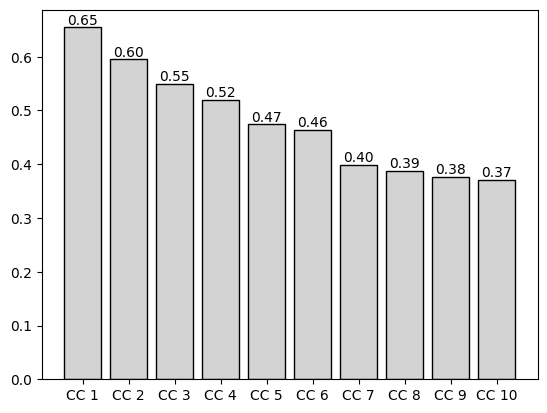

Training CCA, kernel = None, regularization = 0.0100, 10 components
Canonical Correlation Per Component Pair: [0.66839 0.59895 0.56068 0.51905 0.48309 0.46854 0.41393 0.39188 0.38588
 0.37473]
% Shared Variance: [0.44675 0.35874 0.31437 0.26941 0.23337 0.21953 0.17134 0.15357 0.1489
 0.14042]


X1_reduced.shape: (2520, 86)
X2_reduced.shape: (2520, 63)
X1_lags_reduced.shape: (2520, 86)
X2_lags_reduced.shape: (2520, 72)


In [ ]:
cca_no_lag = cca_class.CCAclass(X1=X1_reduced, X2=X2_reduced, lagging_included=False)
cca_no_lag.conduct_cca()

cca_lags = cca_class.CCAclass(X1=X1_lags_reduced, X2=X2_lags_reduced, lagging_included=True)
cca_lags.conduct_cca()

print(f'X1_reduced.shape: {X1_reduced.shape}')
print(f'X2_reduced.shape: {X2_reduced.shape}')
print(f'X1_lags_reduced.shape: {X1_lags_reduced.shape}')
print(f'X2_lags_reduced.shape: {X2_lags_reduced.shape}')

cca_inst = cca_lags